In [37]:
## 수정

import numpy as np
import torch
import torch.nn as nn
import os

class Multimodal():
    def __init__(self):
        self.lengths = None
        self.weights = None
        self.feature_vector_1 = None
        self.feature_vector_2 = None
        self.feature_vector_3 = None
        self._concatenated_vector = None
        self.tensor_result = None

    def upload_vector(self, jitterLocal, Gaze_Vector, Cosine_Similarity, NSP, BERT_Topic):
        self.feature_vector_1 = np.load(jitterLocal)
        self.feature_vector_2 = np.squeeze(np.load(Gaze_Vector))
        self.feature_vector_3 = np.load(Cosine_Similarity)
        self.feature_vector_4 = np.load(NSP)
        self.feature_vector_5 = np.load(BERT_Topic)

        # self.lengths = [len(self.feature_vector_1), len(self.feature_vector_2), len(self.feature_vector_3),len(self.feature_vector_4),len(self.feature_vector_5)]
        self.lengths = [(self.feature_vector_1).size, (self.feature_vector_2).size, (self.feature_vector_3).size,(self.feature_vector_4).size,(self.feature_vector_5).size]

    def minmax_scaling(self):

        ## 가궁치 구하기
        sum_lengths = sum(self.lengths)
        weights = [length / sum_lengths for length in self.lengths]
        ## weight minmax 처리
        # min weight, max weight 구하기
        min_weight = min(weights)
        max_weight = max(weights)
        scaled_weight = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]
        self.weights = scaled_weight
        return self.weights

    def concatenated_vector(self):
        self._concatenated_vector = np.concatenate([
            self.feature_vector_1 / self.weights[0],
            self.feature_vector_2 / self.weights[1],
            self.feature_vector_3 / self.weights[2],
            self.feature_vector_4 / self.weights[3],
            self.feature_vector_5 / self.weights[4]
        ], axis = 0)
        return self._concatenated_vector
    def put_torch(self, jitterLocal, Gaze_Vector, Cosine_Similarity, NSP, BERT_Topic):
      self.upload_vector(jitterLocal, Gaze_Vector, Cosine_Similarity, NSP, BERT_Topic)
      self.minmax_scaling()
      self.concatenated_vector()
      ## result를 tensor에 순서대로 담기
      tensor_result = []
      for data in self._concatenated_vector:
          tensor = torch.tensor(data)
          tensor_result.append(tensor)
      self.tensor_result = tensor_result
      # self.tensor_result = torch.stack(tensor_result)
      return self.tensor_result




    def early_stopping(self, loss_history, patience=10, lowerbound_loss = 1e-4):
        for i in range(1, patience):
            try: 
              if loss_history[-i] < loss_history[-(i+1)] and loss_history[-i] >= lowerbound_loss:
                  patience = 10
                  return False ## 훈련 계속 진행
                  # 현재 에포크의 손실 값이 이전 에포크의 손실 값보다 작거나 같으면서,
                  # 또는 현재 에포크의 손실 값이 1e-4보다 크면 훈련을 계속 진행 (조기 종료하지 않음)
            except: ## 남은게 10개 안남았을 때,
              pass
        return True # 조기 종료로 판단하여 훈련을 종료


    def run_lstm(self, num_epochs=10, y_value = 1):
      # LSTM model definition
      class StackedLSTM(nn.Module):
          def __init__(self, input_size, hidden_size, num_layers, output_size):
              super(StackedLSTM, self).__init__()
              self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
              self.linear = nn.Linear(hidden_size, output_size)
              self.dense = nn.Linear(in_features=output_size, out_features=1)

          def forward(self, x):
              output, _ = self.lstm(x)
              output = self.linear(output[:, -1, :])
              output = self.dense(output)
              return output

      input_size = 1  # 입력 텐서의 feature 차원 크기
      hidden_size = 125
      output_size = 25
      num_layers = 2

      # LSTM model training
      model = StackedLSTM(input_size, hidden_size, num_layers, output_size)
      criterion = nn.BCEWithLogitsLoss()
      optimizer = torch.optim.Adam(model.parameters())

      loss_history = []
      patience = 10
      lowerbound_loss = 1e-4

      for epoch in range(num_epochs):
          optimizer.zero_grad()
          epoch_loss = 0.0

          for data in tensor_result:
            #X = data.unsqueeze(0).unsqueeze(0).float()
            X = data.view(1, -1, 1).float()  
            y = torch.tensor([y_value]).view(-1, 1).float()
            #y = torch.tensor([0, 1]).long() 

            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            print(epoch_loss)

          loss_history.append(epoch_loss)

          if self.early_stopping(loss_history, patience, lowerbound_loss):
              print("Early stopping triggered!")
              break

      return loss_history





# Data Paths

In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
common_drive_path = "/content/drive/MyDrive/AI_Project_14"

good_jitter_path = common_drive_path + '/MP4_GOOD/jitterLocalnp/'
bad_jitter_path = common_drive_path + '/jitterLocal_for_bad_audio(Raw)np/'
good_gaze_path = common_drive_path + '/GAZE/good_gaze/scaled/'
bad_gaze_path = common_drive_path + '/GAZE/bad_gaze/scaled/bad_data/'
good_cos_path = common_drive_path + '/speechtotext/COS/TEST_GOOD/'
bad_cos_path = common_drive_path + '/speechtotext/COS/BAD/'
good_nsp_path = common_drive_path + "/NSP/GOOD/"
bad_nsp_path = common_drive_path + "/NSP/BAD/"
good_topic_path = path = common_drive_path + '/TOPIC2/TOPIC2_GOOD/'
bad_topic_path = path = common_drive_path + '/TOPIC2/TOPIC2_BAD/'


# Make File Name Lists

In [4]:
good_jitter_names = os.listdir(good_jitter_path)
good_gaze_names = os.listdir(good_gaze_path)
good_cos_names = os.listdir(good_cos_path)
good_nsp_names = os.listdir(good_nsp_path)
good_topic_names = os.listdir(good_topic_path)
bad_jitter_names = os.listdir(bad_jitter_path)
bad_gaze_names = os.listdir(bad_gaze_path)
bad_cos_names = os.listdir(bad_cos_path)
bad_nsp_names = os.listdir(bad_nsp_path)
bad_topic_names = os.listdir(bad_topic_path)

good_jitter_names = sorted(good_jitter_names)
good_gaze_names = sorted(good_gaze_names)
good_cos_names = sorted(good_cos_names)
good_nsp_names = sorted(good_nsp_names)
good_topic_names = sorted(good_topic_names)
bad_jitter_names = sorted(bad_jitter_names)
bad_gaze_names = sorted(bad_gaze_names)
bad_cos_names = sorted(bad_cos_names)
bad_nsp_names = sorted(bad_nsp_names)
bad_topic_names = sorted(bad_topic_names)

In [5]:
print(len(good_jitter_names))
print(len(good_gaze_names))
print(len(good_cos_names))
print(len(good_nsp_names))
print(len(good_topic_names))
print(len(bad_jitter_names))
print(len(bad_gaze_names))
print(len(bad_cos_names))
print(len(bad_nsp_names))
print(len(bad_topic_names))

89
89
89
89
89
92
92
92
92
92


# Make Each Features to doubled list

In [3]:
import numpy as np

In [7]:
def load_features(path, file_names):
  vectors = []
  for i, file_name in enumerate(file_names):
    vector = np.load(path + file_name)
    vectors.append(vector)
  return vectors

In [8]:
good_jitter_vectors = load_features(good_jitter_path, good_jitter_names)
good_gaze_vectors = load_features(good_gaze_path, good_gaze_names)
good_cos_vectors = load_features(good_cos_path, good_cos_names)
good_nsp_vectors = load_features(good_nsp_path, good_nsp_names)
good_topic_vectors = load_features(good_topic_path, good_topic_names)

bad_jitter_vectors = load_features(bad_jitter_path, bad_jitter_names)
bad_gaze_vectors = load_features(bad_gaze_path, bad_gaze_names)
bad_cos_vectors = load_features(bad_cos_path, bad_cos_names)
bad_nsp_vectors = load_features(bad_nsp_path, bad_nsp_names)
bad_topic_vectors = load_features(bad_topic_path, bad_topic_names)

# Concatenate features with weights of length

In [9]:
def max_scaled_weight(jitter, gaze, cos, nsp, topic):
    ## 가중치 구하기
    vectors = [jitter, gaze, cos, nsp, topic]
    sum_lengths = 0
    for vector in vectors:
      sum_lengths += vector.shape[0]
    
    weights = [sum_lengths / vector.shape[0] for vector in vectors]
    ## weight minmax 처리
    # min weight, max weight 구하기
    min_weight = min(weights)
    max_weight = max(weights)
    
    scaled_weight = [weight / max_weight for weight in weights]
    weights = scaled_weight
    return weights

In [10]:
def concatenate_vector(jitter, gaze, cos, nsp, topic, weight):
    _concatenated_vector = np.concatenate([
        jitter * weight[0],
        gaze * weight[1],
        cos * weight[2],
        nsp * weight[3],
        topic * weight[4]
    ], axis = 0)
    return _concatenated_vector

In [11]:
for i, vector in enumerate(good_gaze_vectors):
  vector = vector.reshape(-1, )
  good_gaze_vectors[i] = vector

In [12]:
good_gaze_vectors[0].shape

(1270,)

In [13]:
for i, vector in enumerate(bad_gaze_vectors):
  vector = vector.reshape(-1, )
  bad_gaze_vectors[i] = vector

In [1]:
# append each concated vector to X
X = []

In [15]:
for good_jitter, good_gaze, good_cos, good_nsp, good_topic in zip(good_jitter_vectors, good_gaze_vectors, good_cos_vectors, good_nsp_vectors, good_topic_vectors):
  weigths = max_scaled_weight(good_jitter, good_gaze, good_cos, good_nsp, good_topic)
  concated_vector = concatenate_vector(good_jitter, good_gaze, good_cos, good_nsp, good_topic, weigths)
  concated_vector = concated_vector.tolist()
  X.append(concated_vector)

In [16]:
for bad_jitter, bad_gaze, bad_cos, bad_nsp, bad_topic in zip(bad_jitter_vectors, bad_gaze_vectors, bad_cos_vectors, bad_nsp_vectors, bad_topic_vectors):
  weigths = max_scaled_weight(bad_jitter, bad_gaze, bad_cos, bad_nsp, bad_topic)
  concated_vector = concatenate_vector(bad_jitter, bad_gaze, bad_cos, bad_nsp, bad_topic, weigths)
  concated_vector = concated_vector.tolist()
  X.append(concated_vector)

In [17]:
len(X)

181

In [1]:
# Make target vector Y
Y = [1] * 89
for i in range(0, 92, 1):
  Y.append(0)

In [2]:
for i in range(0, 181, 1):
  print(Y[i], end = "")

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [3]:
print(len(Y))
print(min(Y), max(Y))

181
0 1


In [4]:
import numpy as np
X = np.load('../data/final/Concated_X.npy', allow_pickle=True)


# Split and shuffle data

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size = 0.1, shuffle = True, random_state = 2301)

In [7]:
print("Number of Target 1 in train set: ", sum(train_Y))
print("Number of Target 0 in train set: ", len(train_Y) - sum(train_Y))

Number of Target 1 in train set:  81
Number of Target 0 in train set:  81


In [8]:
print(type(train_X))
print(type(val_X))
print(type(train_Y))
print(type(val_Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>


# Convert to tensor

In [9]:
import torch
import torch.nn as nn

In [10]:
def convert_list_to_numpy(lists):
  numpy_list = []
  for vector in lists:
    a = np.array(vector)
    numpy_list.append(a)
  return numpy_list

In [11]:
def convert_vector_to_tensor(vectors):
  tensor_list = []
  for vector in vectors:
    tensor = torch.from_numpy(vector)
    tensor_list.append(tensor)
  return tensor_list

In [12]:
numpy_train_X = convert_list_to_numpy(train_X)
tensor_train_X = convert_vector_to_tensor(numpy_train_X)
numpy_val_X = convert_list_to_numpy(val_X)
tensor_val_X = convert_vector_to_tensor(numpy_val_X)

In [13]:
numpy_train_Y = convert_list_to_numpy(train_Y)
tensor_train_Y = convert_vector_to_tensor(numpy_train_Y)
numpy_val_Y = convert_list_to_numpy(val_Y)
tensor_val_Y = convert_vector_to_tensor(numpy_val_Y)

# Multi Modal

In [14]:
!pip install torchmetrics

In [15]:
def early_stopping(loss_history, patience=10, lowerbound_loss = 1e-4):
    for i in range(1, patience):
        try: 
          if loss_history[-i] < loss_history[-(i+1)] and loss_history[-i] >= lowerbound_loss:
              patience = 10
              return False ## 훈련 계속 진행
              # 현재 에포크의 손실 값이 이전 에포크의 손실 값보다 작거나 같으면서,
              # 또는 현재 에포크의 손실 값이 1e-4보다 크면 훈련을 계속 진행 (조기 종료하지 않음)
        except: ## 남은게 10개 안남았을 때,
          pass
    return True # 조기 종료로 판단하여 훈련을 종료

In [16]:
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryAccuracy

def evaluation(inputs, targets):
    criterion = nn.BCELoss().to(DEVICE)
    predictions = torch.tensor([], dtype=torch.float).to(DEVICE) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float).to(DEVICE) # 실제값을 저장하는 텐서

    with torch.no_grad():
        model.eval() # 평가를 할 때에는 반드시 .eval()  사용
        for x, y in zip(inputs, targets):
            x = x.view(1, -1, 1).float().to(DEVICE)
            y = torch.tensor(y).view(-1, 1).float().to(DEVICE)
            output = model(x)
            #print(type(output))
            predictions = torch.cat((predictions, output.to(DEVICE)), 0) # cat을 통해 예측값을 누적
            actual = torch.cat((actual, y.to(DEVICE)), 0) # cat을 통해 실제값을 누적

    bce = criterion(predictions, actual)
    metric_f1 = BinaryF1Score(threshold = 0.5).to(DEVICE)
    f1 = metric_f1(predictions, actual)
    metric_acc = BinaryAccuracy().to(DEVICE)
    acc = metric_acc(predictions, actual)
    
    model.train()
    return bce, acc, f1

In [28]:
# LSTM model definition
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        #self.linear = nn.Linear(hidden_size, output_size)
        #self.dense = nn.Linear(in_features=output_size, out_features=1)
        self.dense = nn.Linear(in_features=hidden_size, out_features=1)

    def forward(self, x):
        output, _ = self.lstm(x)
        #output = self.linear(output[:, -1, :])
        output = self.dense(output[:, -1, :])
        output = torch.sigmoid(output)
        return output

In [18]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)

cuda


In [19]:
for tensor_list in [tensor_train_X, tensor_train_Y, tensor_val_X, tensor_val_Y]:
    for tensor in tensor_list:
        tensor.to(DEVICE)

In [50]:
input_size = 1  # 입력 텐서의 feature 차원 크기
hidden_size = 16
output_size = 4
num_epochs = 50

# LSTM model training
model = LSTM(input_size, hidden_size, output_size)
model.to(DEVICE)
criterion = nn.BCELoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_history_train = []
loss_history_val = []
acc_history_train = []
acc_history_val = []
f1_histroy_train = []
f1_histroy_val = []
patience = 10
lowerbound_loss = 1e-4

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    # train
    for x, y in zip(tensor_train_X, tensor_train_Y):
      x = x.view(1, -1, 1).float().to(DEVICE)
      y = torch.tensor(y).view(-1, 1).float().to(DEVICE)
      optimizer.zero_grad()  
      
      output = model(x)
      loss = criterion(output, y).to(DEVICE)
      loss.backward()
      optimizer.step()

      #epoch_loss += loss.item()

    train_bce, train_acc, train_f1 = evaluation(tensor_train_X, tensor_train_Y)
    val_bce, val_acc, val_f1 = evaluation(tensor_val_X, tensor_val_Y)

    loss_history_train.append(train_bce.item())
    acc_history_train.append(train_acc.item())
    f1_histroy_train.append(train_f1.item())
    loss_history_val.append(val_bce.item())
    acc_history_val.append(val_acc.item())
    f1_histroy_val.append(val_f1.item())
    print("EPOCH %d --- Train Loss: %.4f, Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy: %.4f, Train F1: %.4f, Validation F1: %.4f" %(epoch + 1, train_bce, val_bce, train_acc, val_acc, train_f1, val_f1)) 
    torch.save(model.state_dict(), '../data/model/model_%d_state_dict.pt'%(epoch + 1))

    # if early_stopping(loss_history_train, patience, lowerbound_loss):
    #     print("Early stopping triggered!")
    #     break
    # validaiton check

C:\Users\JungHwan\AppData\Local\Temp\ipykernel_25744\1889170644.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).float().to(DEVICE)
C:\Users\JungHwan\AppData\Local\Temp\ipykernel_25744\2206577083.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).float().to(DEVICE)


EPOCH 1 --- Train Loss: 0.6919, Validation Loss: 0.6864, Train Accuracy: 0.5000, Validation Accuracy: 0.5789, Train F1: 0.0000, Validation F1: 0.0000
EPOCH 2 --- Train Loss: 0.6905, Validation Loss: 0.6834, Train Accuracy: 0.5000, Validation Accuracy: 0.5789, Train F1: 0.0000, Validation F1: 0.0000
EPOCH 3 --- Train Loss: 0.6524, Validation Loss: 0.6421, Train Accuracy: 0.7716, Validation Accuracy: 0.7895, Train F1: 0.7040, Validation F1: 0.6667
EPOCH 4 --- Train Loss: 0.6869, Validation Loss: 0.6934, Train Accuracy: 0.5000, Validation Accuracy: 0.4211, Train F1: 0.6667, Validation F1: 0.5926
EPOCH 5 --- Train Loss: 0.3451, Validation Loss: 0.3248, Train Accuracy: 0.9938, Validation Accuracy: 1.0000, Train F1: 0.9939, Validation F1: 1.0000
EPOCH 6 --- Train Loss: 0.0820, Validation Loss: 0.0783, Train Accuracy: 1.0000, Validation Accuracy: 1.0000, Train F1: 1.0000, Validation F1: 1.0000
EPOCH 7 --- Train Loss: 0.7259, Validation Loss: 0.7583, Train Accuracy: 0.5000, Validation Accuracy

In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy')

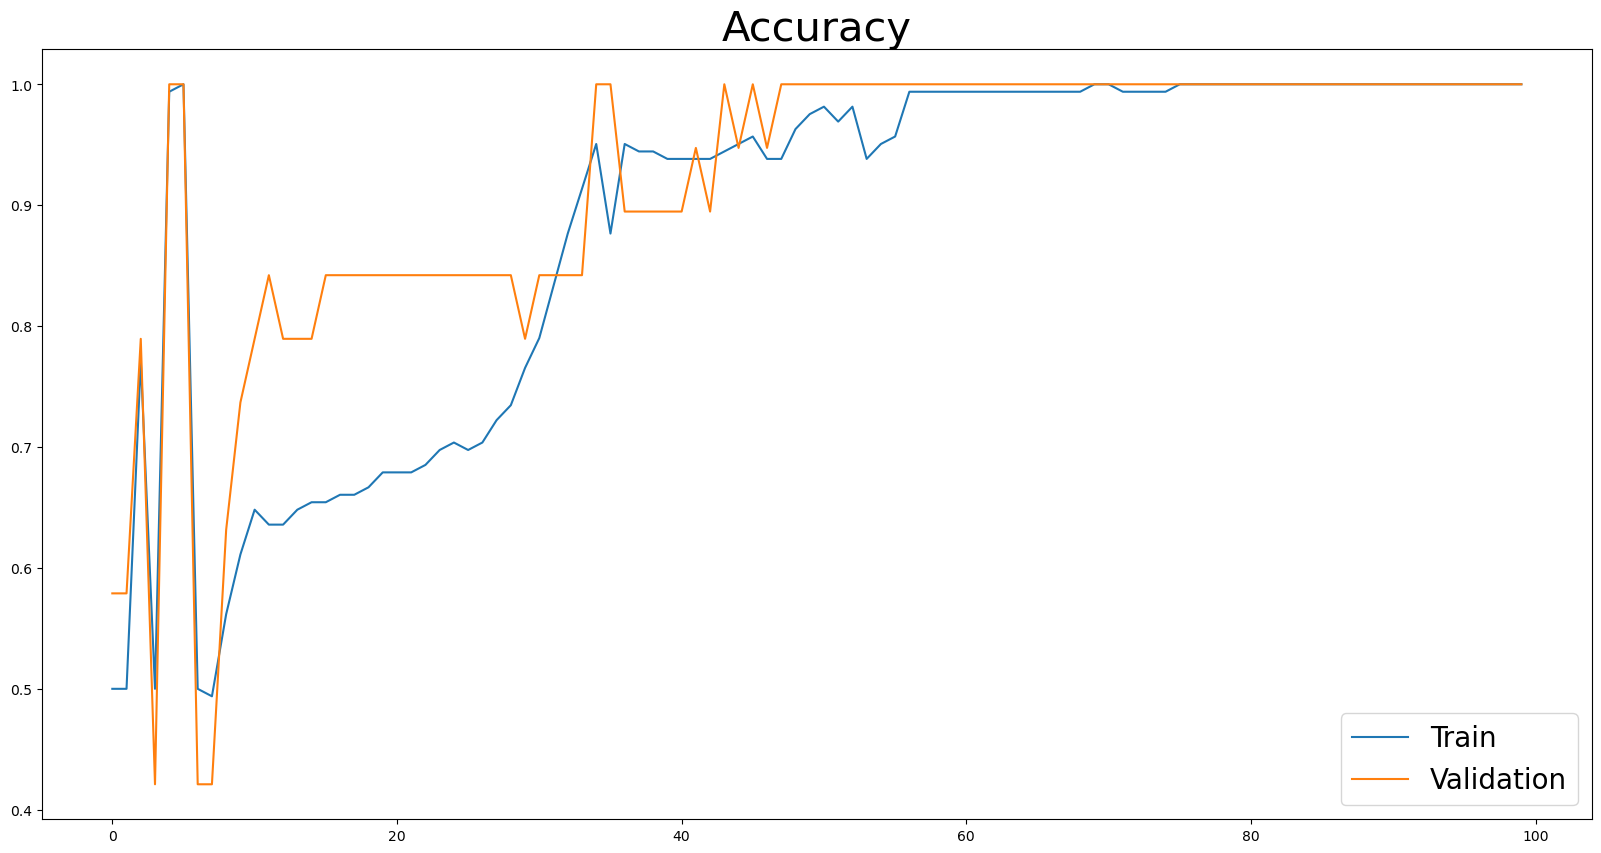

In [55]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(acc_history_train, label = 'Train')
ax.plot(acc_history_val, label = 'Validation')
ax.legend(fontsize = 20)

ax.set_title('Accuracy', fontsize = 30)

Text(0.5, 1.0, 'Loss')

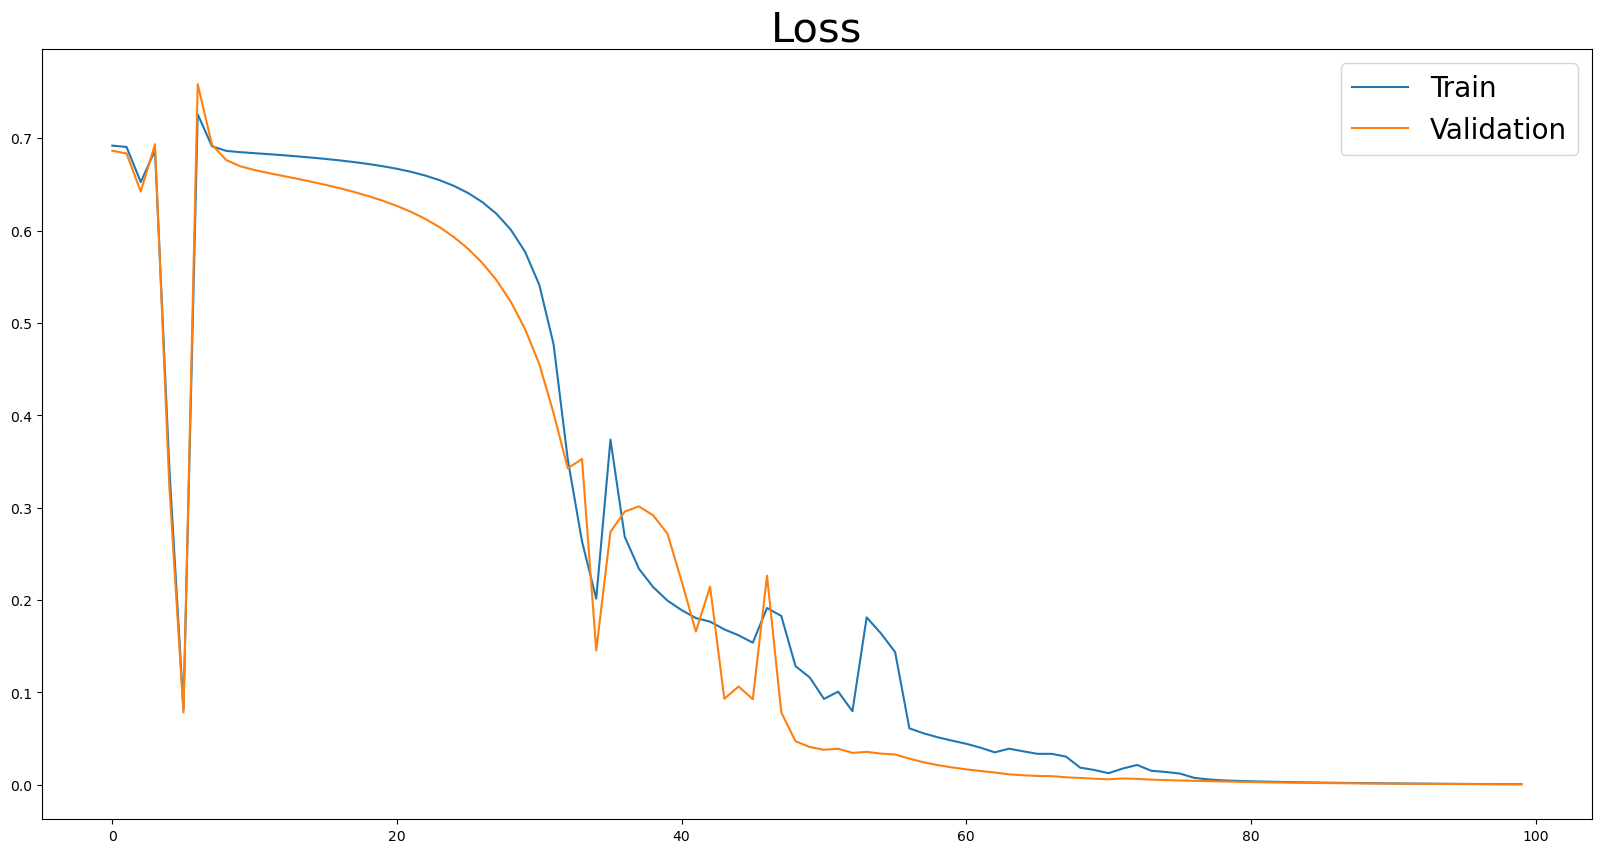

In [57]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.plot(loss_history_train, label = 'Train')
ax.plot(loss_history_val, label = 'Validation')
ax.legend(fontsize = 20)
ax.set_title('Loss', fontsize = 30)

In [53]:
for epoch in range(50, 100, 1):
    epoch_loss = 0.0
    
    # train
    for x, y in zip(tensor_train_X, tensor_train_Y):
      x = x.view(1, -1, 1).float().to(DEVICE)
      y = torch.tensor(y).view(-1, 1).float().to(DEVICE)
      optimizer.zero_grad()  
      
      output = model(x)
      loss = criterion(output, y).to(DEVICE)
      loss.backward()
      optimizer.step()

      #epoch_loss += loss.item()

    train_bce, train_acc, train_f1 = evaluation(tensor_train_X, tensor_train_Y)
    val_bce, val_acc, val_f1 = evaluation(tensor_val_X, tensor_val_Y)

    loss_history_train.append(train_bce.item())
    acc_history_train.append(train_acc.item())
    f1_histroy_train.append(train_f1.item())
    loss_history_val.append(val_bce.item())
    acc_history_val.append(val_acc.item())
    f1_histroy_val.append(val_f1.item())
    print("EPOCH %d --- Train Loss: %.4f, Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy: %.4f, Train F1: %.4f, Validation F1: %.4f" %(epoch + 1, train_bce, val_bce, train_acc, val_acc, train_f1, val_f1)) 
    torch.save(model.state_dict(), '../data/model/model_%d_state_dict.pt'%(epoch + 1))

C:\Users\JungHwan\AppData\Local\Temp\ipykernel_25744\3638429277.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).float().to(DEVICE)
C:\Users\JungHwan\AppData\Local\Temp\ipykernel_25744\2206577083.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).view(-1, 1).float().to(DEVICE)


EPOCH 51 --- Train Loss: 0.0930, Validation Loss: 0.0379, Train Accuracy: 0.9815, Validation Accuracy: 1.0000, Train F1: 0.9814, Validation F1: 1.0000
EPOCH 52 --- Train Loss: 0.1008, Validation Loss: 0.0390, Train Accuracy: 0.9691, Validation Accuracy: 1.0000, Train F1: 0.9689, Validation F1: 1.0000
EPOCH 53 --- Train Loss: 0.0797, Validation Loss: 0.0345, Train Accuracy: 0.9815, Validation Accuracy: 1.0000, Train F1: 0.9816, Validation F1: 1.0000
EPOCH 54 --- Train Loss: 0.1812, Validation Loss: 0.0356, Train Accuracy: 0.9383, Validation Accuracy: 1.0000, Train F1: 0.9351, Validation F1: 1.0000
EPOCH 55 --- Train Loss: 0.1640, Validation Loss: 0.0338, Train Accuracy: 0.9506, Validation Accuracy: 1.0000, Train F1: 0.9487, Validation F1: 1.0000
EPOCH 56 --- Train Loss: 0.1437, Validation Loss: 0.0328, Train Accuracy: 0.9568, Validation Accuracy: 1.0000, Train F1: 0.9554, Validation F1: 1.0000
EPOCH 57 --- Train Loss: 0.0611, Validation Loss: 0.0283, Train Accuracy: 0.9938, Validation A